In [1]:
from glob import glob
import pandas as pd

In [ ]:
from utils.plots import plot_results 
plot_results(save_dir='runs/train/exp2')

In [2]:
files = glob('./runs/detect/exp2/labels/*.txt')

label_dict ={
    '0':1,
    '1':2,
    '2':3,
    '3':4,
}

IMG_HEIGHT = 1080
IMG_WIDTH = 1920

In [3]:
image_filenames,label_ids = list(),list()
xs,ys,ws,hs,confidences = list(),list(),list(),list(),list()

for file in files:
    with open(file,'r') as reader:
        lines = reader.readlines()
        for line in lines:
            line = line.split()
            label, bbox, confidence = line[0], line[1:5], line[5]
            bbox = [float(x) for x in bbox]
            confidence = float(confidence)

            image_filenames.append(file.split('/')[-1].replace('txt','jpg'))
            label_ids.append(label_dict[label])
            ws.append(bbox[2] * IMG_WIDTH)
            hs.append(bbox[3] * IMG_HEIGHT)
            xs.append(bbox[0]*IMG_WIDTH - 0.5*ws[-1])
            ys.append(bbox[1]*IMG_HEIGHT - 0.5*hs[-1])
            confidences.append(confidence)

In [4]:
data = {'image_filename': image_filenames, 
        'label_id': label_ids,
        'x': xs,
        'y': ys,
        'w': ws,
        'h': hs,
        'confidence': confidences
       } 
  
# Create DataFrame 
df = pd.DataFrame(data) 

df.to_csv('yolo_v5s_10.csv',index = False)

In [5]:
df.head()

,image_filename,label_id,x,y,w,h,confidence
0,itp_624.jpg,1,225.999360,559.999440,228.000000,167.000400,0.595703
1,itp_624.jpg,1,1824.000000,584.000280,96.000000,356.000400,0.600098
2,itp_624.jpg,3,1344.999840,591.999840,99.000000,214.999920,0.750977
3,itp_624.jpg,1,1210.999680,618.000300,120.000000,93.999960,0.767578
4,itp_624.jpg,3,1015.000992,607.999878,51.999936,104.000004,0.789551


## demo

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import colorsys
import random
from PIL import Image
import cv2
import numpy as np

In [7]:
labels = ['vehicle', 'pedesrtrian', 'scooter', 'bicycle']

def draw_bbox(filename, bboxes, thres = 0.5, classes=labels, show_label=True):
    """
    This function can help you examine your model's prediction.
    
    arguments:
        filename: image_filename in submission.csv i.e. 'itp_1.jpg'
        bboxes: [x_min, y_min, w, h, confidence, label_id] format coordinates.
        
    """
    filename = '../../ivslab_test_public/JPEGImages/All/' + filename
    image = cv2.imread(filename)
    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        if score < thres:
            continue
        class_ind = int(bbox[5])-1
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[0]+coor[2], coor[1]+coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)  # filled

            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image

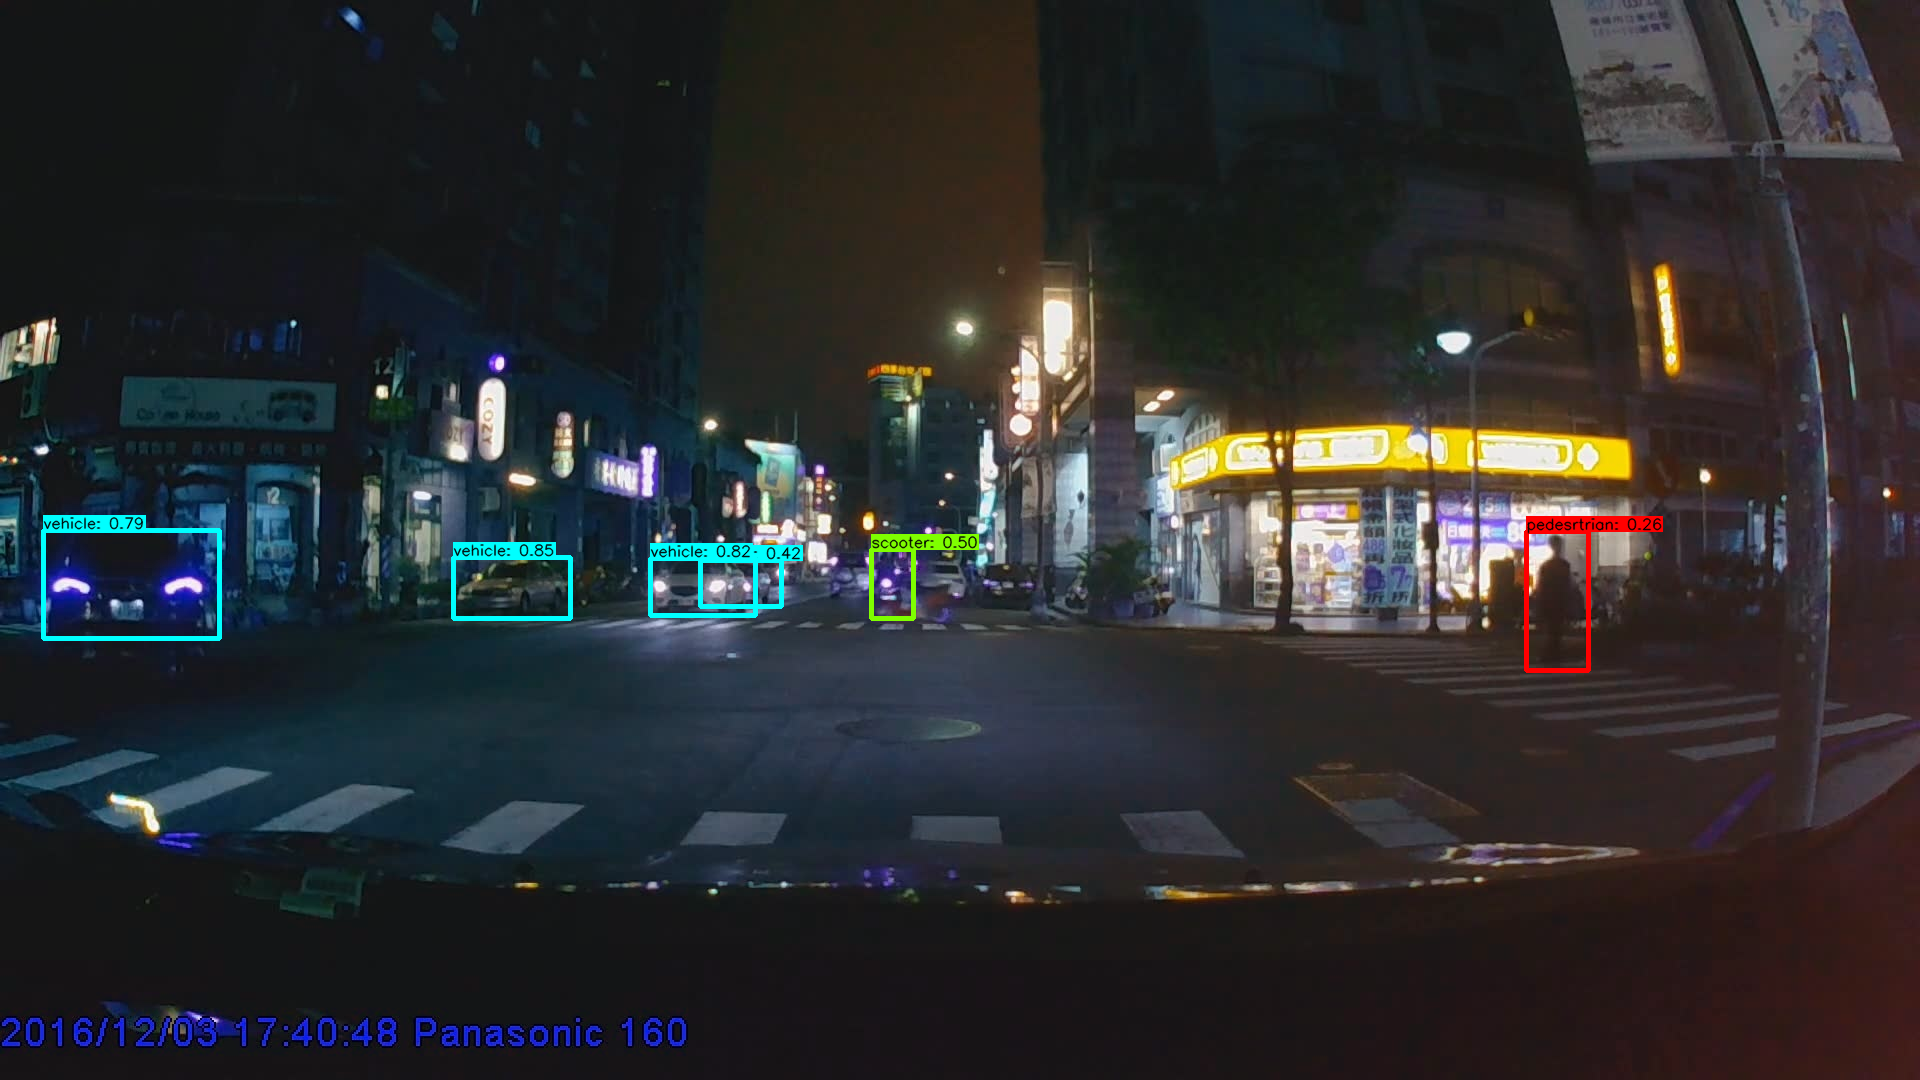

In [11]:
#submission = pd.read_csv('OIFO.csv')

filename = 'itp_1.jpg'
boxes = df.loc[df['image_filename'] == filename][['x','y','w','h','confidence','label_id']].values
labels = ['vehicle', 'pedesrtrian', 'scooter', 'bicycle']
image = draw_bbox(filename,boxes,0,labels)
image = Image.fromarray(image)

image